<a href="https://colab.research.google.com/github/raphaelp-silva/GNN_Pytorch_geometric/blob/main/Training_GNN_with_Optuna.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
!pip install torch-geometric
!pip install --upgrade skorch
!pip install optuna

In [23]:
import pandas as pd
import numpy as np
import torch
from torch_geometric.data import Data
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, BatchNorm
import torch.nn as nn
from skorch import NeuralNetClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from torch_geometric.data import DataLoader
from sklearn.metrics import accuracy_score
import optuna
from torch_geometric.utils import subgraph
import random

In [24]:
# carregando os grafos:

graph_train = torch.load('/content/graph_train.pt', weights_only=False)
graph_test = torch.load('/content/graph_test.pt', weights_only=False)
graph_val = torch.load('/content/graph_val.pt', weights_only=False)

In [25]:
# verificando o tamanho dos 3 grafos (treinamento, teste e validação):

print(graph_train.x.shape)
print(graph_test.x.shape)
print(graph_val.x.shape)

torch.Size([1477, 26])
torch.Size([317, 26])
torch.Size([317, 26])


In [26]:
# verificando o grafo de treinamento:

print(graph_train.x.shape)
print(graph_train.edge_index.shape)
print(graph_train.y.shape)

torch.Size([1477, 26])
torch.Size([2, 14770])
torch.Size([1477, 7])


In [27]:
graph_train = Data(x = graph_train.x, edge_index=graph_train.edge_index, y=graph_train.y)
print(graph_train)

graph_test = Data(x = graph_test.x, edge_index=graph_test.edge_index, y=graph_test.y)
print(graph_test)

graph_val = Data(x = graph_val.x, edge_index=graph_val.edge_index, y=graph_val.y)
print(graph_val)

Data(x=[1477, 26], edge_index=[2, 14770], y=[1477, 7])
Data(x=[317, 26], edge_index=[2, 3170], y=[317, 7])
Data(x=[317, 26], edge_index=[2, 3170], y=[317, 7])


In [28]:
class GNN(torch.nn.Module):
    def __init__(self, activation, neurons, dropout, num_layers=4):
        super(GNN, self).__init__()

        self.activation = activation
        self.dropout = nn.Dropout(dropout)
        self.num_layers = num_layers

        self.convs = nn.ModuleList()
        self.bns = nn.ModuleList()

        in_channels = 26
        hidden_sizes = [neurons]

        # Gerar a arquitetura com redução progressiva
        for i in range(1, num_layers):
            next_size = max(4, hidden_sizes[-1] // 2)
            hidden_sizes.append(next_size)

        # Criar camadas convolucionais e de batch norm
        for i in range(num_layers):
            out_channels = hidden_sizes[i]
            self.convs.append(GCNConv(in_channels, out_channels))
            self.bns.append(BatchNorm(out_channels))
            in_channels = out_channels  # para a próxima camada

        # Camadas Fully Connected (ajuste conforme o número de classes)
        self.fc1 = nn.Linear(hidden_sizes[-1], hidden_sizes[-1] // 2)
        self.fc2 = nn.Linear(hidden_sizes[-1] // 2, 7)  # 7 classes

        # Reset de parâmetros das camadas GCN
        for conv in self.convs:
            conv.reset_parameters()

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        for i in range(self.num_layers):
            x = self.convs[i](x, edge_index)
            x = self.bns[i](x)
            x = self.activation(x)
            x = self.dropout(x)

        x = self.fc1(x)
        x = self.activation(x)
        x = self.fc2(x)

        return F.log_softmax(x, dim=1)


In [29]:
# setando o seed:

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


# Criando a função 'objective' para otimizar parametros com optuna:

# Definindo a função objetivo do Optuna
def objective(trial):
    set_seed(42 + trial.number) #seed controlada por trial para variar um pouco entre as execucoes

    # Hiperparâmetros sugeridos através do Optuna
    neurons = trial.suggest_int("neurons", 64, 512)  # número de neurônios nas camadas ocultas
    dropout = trial.suggest_float("dropout", 0.05, 0.5, step=0.05)  # taxa de dropout
    lr = trial.suggest_float("lr", 6e-5, 1, log=True)  # taxa de aprendizado
    num_layers = trial.suggest_int("num_layers", 2, 6)
    # Criar o modelo com os parâmetros sugeridos
    model = GNN(activation=torch.nn.LeakyReLU(),
                neurons=neurons,
                dropout=dropout,
                num_layers=num_layers)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.CrossEntropyLoss()

    # Treinamento
    model.train()
    for epoch in range(50):
        optimizer.zero_grad()
        out = model(graph_train)

        target = graph_train.y
        if target.dim() > 1:
          target = torch.argmax(target, dim=1)

        loss = criterion(out, target)
        loss.backward()
        optimizer.step()

    # Validação
    model.eval()
    predictions = []
    true_labels = []

    with torch.no_grad():
        out = model(graph_test)
        pred = torch.argmax(out, dim=1)

        true_labels = graph_test.y
        if true_labels.dim()>1:
          true_labels = torch.argmax(true_labels, dim=1)

        predictions.append(pred)
        true_labels = true_labels.to(torch.int64)
        predictions = pred.to(torch.int64)


    # Calculando a acurácia
    accuracy = accuracy_score(true_labels.cpu().numpy(), predictions.cpu().numpy())

    return accuracy  # Retorne a acurácia para o Optuna


In [30]:
# Criando um estudo para maximizar a métrica de desempenho (ex: acurácia)
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=300)  # Defina o número de tentativas

[I 2025-04-07 18:31:02,349] A new study created in memory with name: no-name-a433e353-bb08-4cd5-b3f6-a9729ddd4a36
[I 2025-04-07 18:31:18,330] Trial 0 finished with value: 0.2555205047318612 and parameters: {'neurons': 458, 'dropout': 0.45, 'lr': 6.065386630945389e-05, 'num_layers': 4}. Best is trial 0 with value: 0.2555205047318612.
[I 2025-04-07 18:31:31,597] Trial 1 finished with value: 0.29337539432176657 and parameters: {'neurons': 355, 'dropout': 0.45, 'lr': 0.00017217770355548685, 'num_layers': 5}. Best is trial 1 with value: 0.29337539432176657.
[I 2025-04-07 18:31:45,780] Trial 2 finished with value: 0.583596214511041 and parameters: {'neurons': 489, 'dropout': 0.05, 'lr': 0.03952397341201661, 'num_layers': 4}. Best is trial 2 with value: 0.583596214511041.
[I 2025-04-07 18:31:50,742] Trial 3 finished with value: 0.5078864353312302 and parameters: {'neurons': 274, 'dropout': 0.05, 'lr': 0.30972764394342683, 'num_layers': 4}. Best is trial 2 with value: 0.583596214511041.
[I 202

In [31]:
print("Melhores hiperparâmetros encontrados:")
print(study.best_params)

print("Melhor valor da métrica de avaliação:")
print(study.best_value)

Melhores hiperparâmetros encontrados:
{'neurons': 403, 'dropout': 0.35000000000000003, 'lr': 0.0010151776386525364, 'num_layers': 2}
Melhor valor da métrica de avaliação:
0.7634069400630915


In [32]:
import optuna.visualization as vis

# Gráfico da convergência (mostra a evolução da métrica ao longo dos trials)
vis.plot_optimization_history(study).show()

# Importância dos hiperparâmetros
vis.plot_param_importances(study).show()

# Treinando novamente o modelo, utilizando os melhores parâmetros encontrados para testar os resultados

In [33]:
# Fixar seed novamente para reprodutibilidade:
set_seed(42)

# Criar o modelo com os melhores parâmetros
best_model = GNN(
    activation=torch.nn.LeakyReLU(),
    neurons= study.best_params["neurons"],
    dropout= study.best_params["dropout"],
    num_layers= study.best_params["num_layers"]
)

optimizer = torch.optim.Adam(best_model.parameters(), lr=study.best_params["lr"])
criterion = torch.nn.CrossEntropyLoss()

# Treinamento completo:
best_model.train()
for epoch in range(300):
    optimizer.zero_grad()
    out = best_model(graph_train)

    target = graph_train.y
    if target.dim() > 1:
        target = torch.argmax(target, dim=1)

    loss = criterion(out, target)
    loss.backward()
    optimizer.step()


In [34]:
# Avaliação no grafo final de teste:
best_model.eval()

with torch.no_grad():
    out = best_model(graph_test)
    pred = torch.argmax(out, dim=1)

    true_labels = graph_test.y
    if true_labels.dim() > 1:
        true_labels = torch.argmax(true_labels, dim=1)

    accuracy = accuracy_score(true_labels.cpu().numpy(), pred.cpu().numpy())
    print(f"Acurácia no grafo de teste final: {accuracy:.4f}")


Acurácia no grafo de teste final: 0.7256


In [35]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [36]:
best_model.eval()
with torch.no_grad():
    out = best_model(graph_test)
    y_pred = torch.argmax(out, dim=1).cpu().numpy()
    y_true = graph_test.y.cpu().numpy()
    if y_true.ndim > 1:
        y_true = np.argmax(y_true, axis=1)


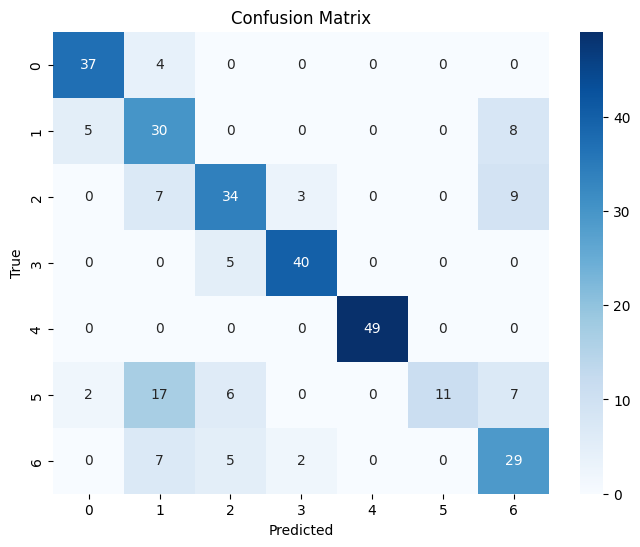

In [37]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(7), yticklabels=range(7))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [38]:
print(classification_report(y_true, y_pred, digits=3))

              precision    recall  f1-score   support

           0      0.841     0.902     0.871        41
           1      0.462     0.698     0.556        43
           2      0.680     0.642     0.660        53
           3      0.889     0.889     0.889        45
           4      1.000     1.000     1.000        49
           5      1.000     0.256     0.407        43
           6      0.547     0.674     0.604        43

    accuracy                          0.726       317
   macro avg      0.774     0.723     0.712       317
weighted avg      0.776     0.726     0.716       317

